# DPC Location-Allocation Model

### Problem Definition

> **Given**:
> * A set of client locations, each with a known population (`wi`).
> * A set of candidate locations for opening DPCs.
> * A policy decision on the total number of DPCs to open (`p`).
> * A viability threshold specifying the minimum number of clients an open DPC must serve (`Wmin`).

> **Objective**:
> To find the optimal locations for the `p` DPCs and the corresponding allocation of clients to them, such that the **total expected number of participating clients is maximized**.

---

### Mathematical Formulation

#### Variables

$$
x_j = \begin{cases}
1 & \text{if a DPC is opened at candidate location } j \\
0 & \text{otherwise}
\end{cases}
$$

$$
y_{ij} = \begin{cases}
1 & \text{if client point } i \text{ is assigned to a DPC at location } j \\
0 & \text{otherwise}
\end{cases}
$$

#### Model

$$
\begin{align}
\max \quad & \sum_{i \in I} \sum_{j \in J} \sigma_{ij} y_{ij} \\
\text{s.t.} \quad & \\
& \sum_{j \in J} x_j = p \\
& \sum_{j \in J} y_{ij} \le 1, \quad \forall i \in I \\
& \sum_{i \in I} \sigma_{ij} y_{ij} \ge W_{\min} x_j, \quad \forall j \in J \\
& y_{ij} \le x_j, \quad \forall i \in I, j \in J \\
& x_j \in \{0, 1\}, \quad y_{ij} \in \{0, 1\}
\end{align}
$$


## Setup

In [1]:
# ## 1. Setup and Imports
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
import math

class args:
    figsize = (12, 12)

In [2]:
# ## 2. Drawing Functions
def DrawInitG(client_nodes, candidate_nodes, G):
    """Draws the initial problem setup."""
    plt.figure(figsize=args.figsize)
    pos = {i: (G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    # Draw client nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=client_nodes.keys(),
                           node_shape='s',  # Square for clients
                           node_size=500,
                           node_color='skyblue',
                           label="Client Locations")
    
    # Draw candidate DPC locations
    nx.draw_networkx_nodes(G, pos,
                           nodelist=candidate_nodes.keys(),
                           node_shape='o',  # Circle for candidates
                           node_size=500,
                           node_color='lightgreen',
                           label="Candidate DPC Locations")

    nx.draw_networkx_labels(G, pos, font_color='black', font_size=10)
    plt.title("Initial Problem Setup")
    plt.axis('off')
    plt.show()

def DrawSol(client_nodes, candidate_nodes, G, x, y):
    """
    Draws the solution, highlighting the active network (open DPCs and assigned clients)
    and fading out the inactive nodes.
    """
    plt.figure(figsize=args.figsize)
    pos = {i: (G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    # --- 1. Identify active and inactive nodes from the solution ---
    open_dpcs = {j for j in candidate_nodes if x[j].x > 0.9}
    
    # Get all clients that are assigned to any DPC
    assigned_clients = {i for i, j in y if y[i, j].x > 0.9}
    
    # Get all nodes that are part of the solution
    active_nodes = open_dpcs.union(assigned_clients)
    
    # Get all nodes that are NOT part of the solution
    inactive_nodes = set(G.nodes()) - active_nodes
    
    # --- 2. Draw the assignment edges for the active network ---
    assignment_edges = [(i, j) for i, j in y if y[i, j].x > 0.9]
    nx.draw_networkx_edges(G, pos,
                           edgelist=assignment_edges,
                           edge_color='black',
                           style='solid',
                           width=1.5)
    
    # --- 3. Draw the nodes in layers (inactive first, then active) ---
    # Draw inactive nodes (faded out)
    nx.draw_networkx_nodes(G, pos,
                           nodelist=list(inactive_nodes),
                           node_size=500,
                           node_color='gray',
                           alpha=0.3) # Use alpha for a faded effect

    # Draw active client nodes (clear and bright)
    nx.draw_networkx_nodes(G, pos,
                           nodelist=list(assigned_clients),
                           node_shape='s',
                           node_size=600,
                           node_color='skyblue',
                           edgecolors='black')

    # Draw active (opened) DPC nodes (clear and bright)
    nx.draw_networkx_nodes(G, pos,
                           nodelist=list(open_dpcs),
                           node_shape='o',
                           node_size=900,
                           node_color='green',
                           edgecolors='black')

    # --- 4. Draw labels for all nodes ---
    nx.draw_networkx_labels(G, pos, font_color='black', font_size=10)
    
    plt.title("Optimal DPC Locations and Client Assignments")
    plt.axis('off')
    plt.show()

## Data preparation

In [3]:
USE_TOY_MODEL = False

if USE_TOY_MODEL:
    # Create a toy problem instance.
    # We will represent all locations (clients and candidates) in a single graph.
    # Node attributes will distinguish them.
    
    # Define client locations with their coordinates and populations
    client_nodes = {
        1: {'x': 10, 'y': 20, 'pop': 1500},
        2: {'x': 15, 'y': 55, 'pop': 800},
        3: {'x': 30, 'y': 45, 'pop': 2200},
        4: {'x': 50, 'y': 60, 'pop': 1200},
        5: {'x': 60, 'y': 25, 'pop': 3100},
        6: {'x': 40, 'y': 10, 'pop': 900},
    }
    
    # Define candidate DPC locations with their coordinates
    candidate_nodes = {
        101: {'x': 20, 'y': 35},
        102: {'x': 55, 'y': 45},
        103: {'x': 35, 'y': 15},
    }

If `USE_TOY_MODEL` is False, we'll use a real-world dataset of Chicago "client location" and "candidate facility locations". Initially, I looked for data on Lviv (my home town) that shows where people live and how many there are in each area, along with map coordinates. I did find some sources, but most of them were in formats like PDFs or shapefiles, or the information was split across different files that would need a lot of work to combine and clean. So instead, I decided to use an alternative.

I chose data from Chicago that lists 
- **public schools with their locations and number of students**, and
- **public libraries as possible facility sites**.

It’s obviously not a perfect match, but I thought schools locations can be a rough proxy for where people are (since they’re spread across neighborhoods and reflect local demand), and libraries make sense as public buildings that could represent places where a healthcare center might be built.

In [4]:
import pandas as pd
import networkx as nx

if not USE_TOY_MODEL:
    # --- Sampling Parameters ---
    # Set to an integer to sample a specific number of nodes.
    # Set to None to use the full dataset.
    N_CLIENTS_TO_SAMPLE = 100  # Sample 100 clients out of 652
    M_CANDIDATES_TO_SAMPLE = 20   # Sample 20 candidates out of 81
    
    # --- Data Loading ---
    try:
        clients_df_full = pd.read_csv('chicago_clients.csv')
        candidates_df_full = pd.read_csv('chicago_candidates.csv')
    except FileNotFoundError:
        print("Data files not found. Please run a data preparation script first. (`prepare_data.py`)")
        # If you have a prepare_data.py script, you might suggest running it here.
        exit()
    
    # Sample client nodes
    # Using a fixed random_state ensures the sample is the same every time.
    if N_CLIENTS_TO_SAMPLE and N_CLIENTS_TO_SAMPLE < len(clients_df_full):
        clients_df = clients_df_full.sample(n=N_CLIENTS_TO_SAMPLE, random_state=42)
        print(f"Sampled {len(clients_df)} clients out of {len(clients_df_full)} total.")
    else:
        clients_df = clients_df_full
        print(f"Using all {len(clients_df)} clients.")
    
    # Sample candidate nodes
    if M_CANDIDATES_TO_SAMPLE and M_CANDIDATES_TO_SAMPLE < len(candidates_df_full):
        candidates_df = candidates_df_full.sample(n=M_CANDIDATES_TO_SAMPLE, random_state=42)
        print(f"Sampled {len(candidates_df)} candidate locations out of {len(candidates_df_full)} total.")
    else:
        candidates_df = candidates_df_full
        print(f"Using all {len(candidates_df)} candidate locations.")
    
    # --- Prepare Data for the Model ---
    client_nodes = {
        row['id']: {'x': row['longitude'], 'y': row['latitude'], 'pop': row['population']}
        for index, row in clients_df.iterrows()
    }
    
    candidate_nodes = {
        row['id']: {'x': row['longitude'], 'y': row['latitude']}
        for index, row in candidates_df.iterrows()
    }

Sampled 100 clients out of 652 total.
Sampled 20 candidate locations out of 81 total.



Graph created with 100 client nodes and 20 candidate nodes.


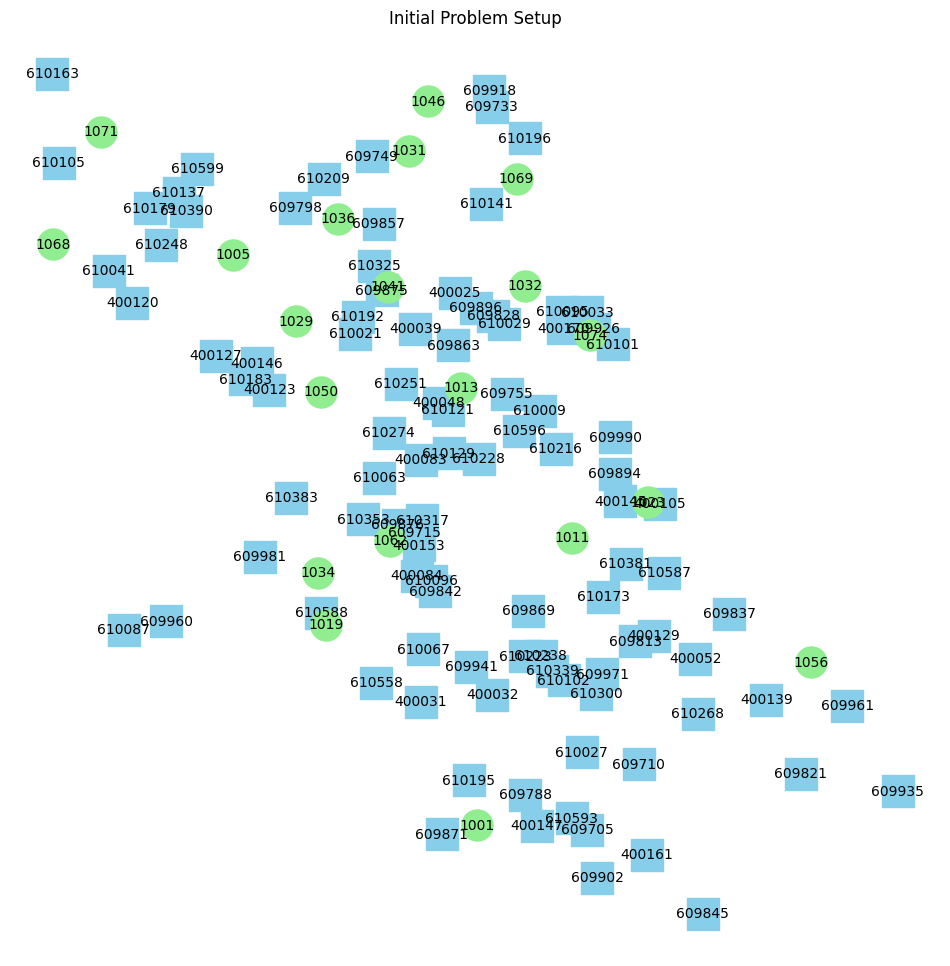

In [5]:
# We will represent all locations in a single graph for visualization.
G = nx.Graph()

# Add nodes to the graph from the sampled data
for node, attr in client_nodes.items():
    G.add_node(node, **attr, type='client')
for node, attr in candidate_nodes.items():
    G.add_node(node, **attr, type='candidate')

print(f"\nGraph created with {len(client_nodes)} client nodes and {len(candidate_nodes)} candidate nodes.")

# Visualize the initial setup of the sampled data
DrawInitG(client_nodes, candidate_nodes, G)

## Model Parameters definition

In [6]:
if USE_TOY_MODEL:
    # Policy parameters
    p = 2      # Number of DPCs to open
    Wmin = 2000 # Minimum required clients for a DPC to be viable
    
    # Elastic demand parameter
    max_dist = 40 # Maximum distance a client is willing to travel
else:
    # Policy parameters
    p = 10 # Number of DPCs to open
    
    # Let's calculate the total population of our sample in order to set a reasonable viability threshold.
    total_sampled_population = sum(v['pop'] for v in client_nodes.values())
    print(f"\nTotal population in client sample: {total_sampled_population}")
    
    # Let's set the viability threshold to something achievable with this number of DPCs
    # For example, 5% of the total sampled population.
    Wmin = int(total_sampled_population * 0.05)
    print(f"Viability threshold (Wmin) set to: {Wmin}")
    
    # Elastic demand parameter
    # Because we use latitute/longitude units here, it is in degrees
    max_dist = 0.5


Total population in client sample: 45183
Viability threshold (Wmin) set to: 2259


In [7]:
# Pre-calculate Elastic Demand
# using the Euclidean distance func below
def euclidean_dist(p1, p2):
    return math.sqrt((p1['x'] - p2['x'])**2 + (p1['y'] - p2['y'])**2)

# Calculate sigma values based on a linear decay function
sigma = {}
for i, i_attr in client_nodes.items():
    for j, j_attr in candidate_nodes.items():
        dist = euclidean_dist(i_attr, j_attr)
        if dist <= max_dist:
            # Participation decreases linearly with distance
            participation_rate = 1.0 - (dist / max_dist)
            sigma[i, j] = i_attr['pop'] * participation_rate
        else:
            sigma[i, j] = 0

# sigma

## Gurobi model definiton

In [8]:
dpc_model = gb.Model("DPC_Location_Model")

# Define Decision Variables

# x_j = 1 if DPC is opened at location j
x = dpc_model.addVars(candidate_nodes.keys(), vtype=gb.GRB.BINARY, name="x")

# y_ij = 1 if client i is assigned to DPC j
y = dpc_model.addVars(sigma.keys(), vtype=gb.GRB.BINARY, name="y")

# Set Objective Function
dpc_model.setObjective(y.prod(sigma), sense=gb.GRB.MAXIMIZE)

dpc_model.update()
dpc_model.write('dpc_model.lp')

Set parameter Username
Set parameter LicenseID to value 2627744
Academic license - for non-commercial use only - expires 2026-02-25


In [9]:
# Add Constraints

# Constraint (51): Open exactly p DPCs
dpc_model.addConstr(x.sum() == p, name="num_dpcs")

# Constraint (52): Each client is assigned to at most one DPC
dpc_model.addConstrs((y.sum(i, '*') <= 1 for i in client_nodes.keys()), name="assign_client")

# Constraint (54): Clients can only be assigned to open DPCs (linking constraint)
dpc_model.addConstrs((y[i, j] <= x[j] for i, j in sigma.keys()), name="link_y_x")

# Constraint (53): Each open DPC must meet the minimum client threshold
dpc_model.addConstrs(
    (gb.quicksum(sigma[i, j] * y[i, j] for i in client_nodes.keys()) >= Wmin * x[j]
     for j in candidate_nodes.keys()), name="viability")

dpc_model.update()
dpc_model.write('dpc_model.lp') # Save the model formulation for inspection

## Optimization and results

In [10]:
dpc_model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2121 rows, 2020 columns and 8020 nonzeros
Model fingerprint: 0x2cda11ce
Variable types: 0 continuous, 2020 integer (2020 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [4e+01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 21 rows and 20 columns
Presolve time: 0.03s
Presolved: 2100 rows, 2000 columns, 7960 nonzeros
Variable types: 0 continuous, 2000 integer (2000 binary)
Found heuristic solution: objective 29224.211108
Found heuristic solution: objective 33044.204653

Root relaxation: objective 4.244286e+04, 147 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |


Optimal Objective (Total Expected Clients): 42442.86

Optimal DPC Locations:
 -> DPC at location 1031 is OPENED.
 -> DPC at location 1001 is OPENED.
 -> DPC at location 1019 is OPENED.
 -> DPC at location 1011 is OPENED.
 -> DPC at location 1013 is OPENED.
 -> DPC at location 1068 is OPENED.
 -> DPC at location 1074 is OPENED.
 -> DPC at location 1062 is OPENED.
 -> DPC at location 1056 is OPENED.
 -> DPC at location 1041 is OPENED.

Client Assignments: (Top 10)
 -> Client 609813 is assigned to DPC 1011.
 -> Client 610102 is assigned to DPC 1011.
 -> Client 609869 is assigned to DPC 1011.
 -> Client 400123 is assigned to DPC 1041.
 -> Client 610268 is assigned to DPC 1056.
 -> Client 610596 is assigned to DPC 1013.
 -> Client 400161 is assigned to DPC 1001.
 -> Client 610300 is assigned to DPC 1011.
 -> Client 610096 is assigned to DPC 1062.
 -> Client 609871 is assigned to DPC 1001.
 -> Client 400084 is assigned to DPC 1062.


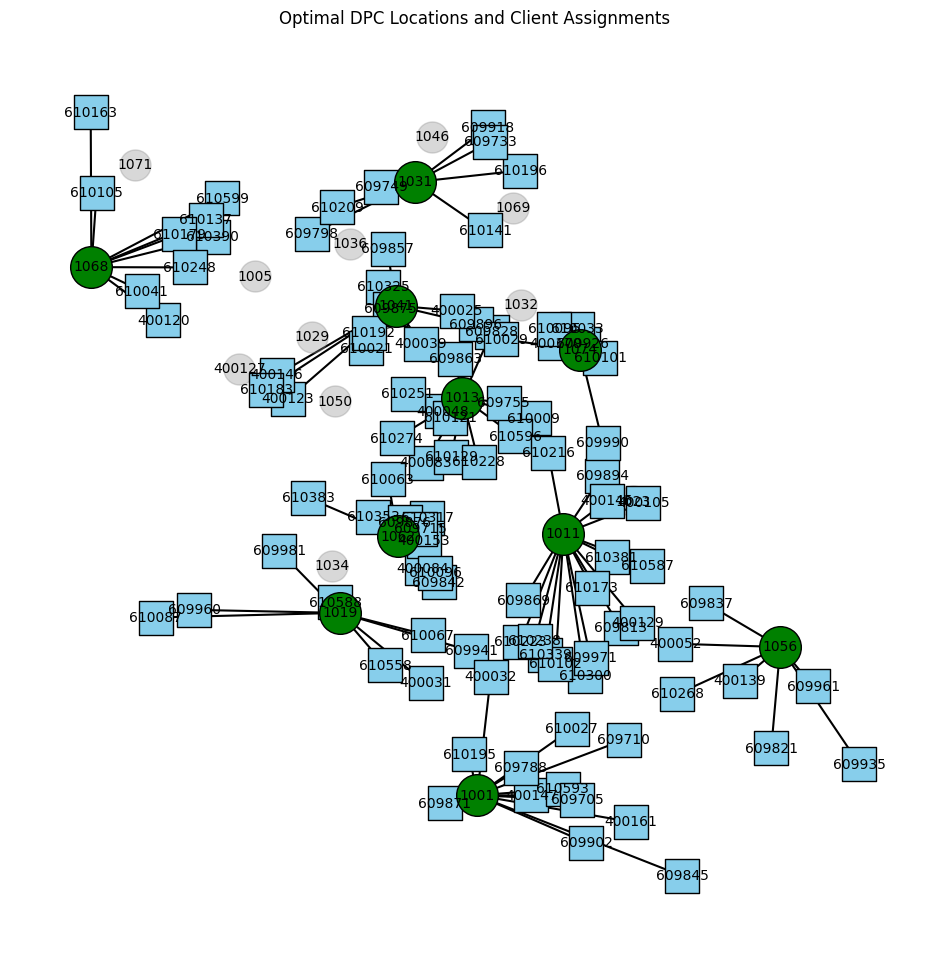

In [11]:
# Print and Visualize Solution

if dpc_model.status == gb.GRB.OPTIMAL:
    print(f"\nOptimal Objective (Total Expected Clients): {dpc_model.objVal:.2f}\n")
    
    print("Optimal DPC Locations:")
    for j in candidate_nodes:
        if x[j].x > 0.5:
            print(f" -> DPC at location {j} is OPENED.")
            
    print("\nClient Assignments: (Top 10)")
    for idx, i in enumerate(client_nodes):
        if idx > 10: break # only show top 10 clients
        for j in candidate_nodes:
            if y[i, j].x > 0.5:
                print(f" -> Client {i} is assigned to DPC {j}.")
                
    # Draw the solution graph
    DrawSol(client_nodes, candidate_nodes, G, x, y)
    
elif dpc_model.status == gb.GRB.INFEASIBLE:
    print("The model is infeasible. This could be because the viability constraint (Wmin) is too high or the number of DPCs (p) is too low.")
else:
    print(f"Optimization finished with status: {dpc_model.status}")